In [14]:
import numpy as np
import torch
import torch.nn as nn
import pickle
from torch.utils.data import Dataset, DataLoader

In [4]:
class SIRSimulatedData(Dataset):
    
    def __init__(self, path='data/data.pkl', partition='train'):
        super(SIRSimulatedData).__init__()
    
        with open(path, 'rb') as f:
            
            data, labels = pickle.load(f)
            
        if partition == 'train':
            self.data, self.labels = data[:16000], labels[:16000]
        
        elif partition == 'dev':
            self.data, self.labels = data[16000:18000], labels[16000:18000]
        
        elif partition == 'test':
            self.data, self.labels = data[18000:], labels[18000:]
            
        
    def __len__(self):
        
        return len(self.labels)
    
    def __getitem__(self, index):
        
        return self.data[index], self.labels[index]

In [12]:
train_data = SIRSimulatedData(partition='train')
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)


In [13]:
X, y = next(iter(train_loader))
X.shape

torch.Size([10, 366, 3])

In [28]:
class Network(nn.Module):
    
    def __init__(self, num_layers, num_hidden, bidirectional=False):
        super(Network, self).__init__()
        
        self.num_layers = num_layers
        self.num_hidden = num_hidden
        
        if bidirectional:
            self.bidirectional_multiplier = 2
        else:
            self.bidirectional_multiplier = 1
        
        self.rnn = nn.RNN(input_size=3, 
                          hidden_size=self.num_hidden,
                          num_layers=self.num_layers,
                          dropout=0,
                          bidirectional=bidirectional)
        
        self.reg = nn.Sequential(*[nn.Linear(self.num_hidden * self.bidirectional_multiplier, 2048),
                                   nn.Linear(2048, 1)])
    
    def forward(self, X):
        
        out, _ = self.rnn(X)
        out = self.reg(out)
        
        return out

In [32]:
model = Network(num_layers=4, num_hidden=128, bidirectional=True)
out = model(X.float()).squeeze()

In [33]:
out.shape

torch.Size([10, 366])

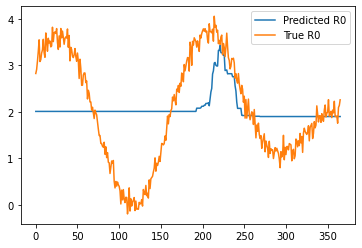

In [32]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from train import validation
from datasets.dataset import SIRSimulatedData

CHECKPOINT_MODEL_DIR = "models/trained_models/model_20220409_225415_checkpoint_2.pkl"
model = torch.load(CHECKPOINT_MODEL_DIR).cuda()

SAMPLE_NUMBER = 9

val_data = SIRSimulatedData(partition='dev')
data, labels = val_data[SAMPLE_NUMBER]

data = torch.tensor(data).unsqueeze(0)
labels = torch.tensor(labels).unsqueeze(0)

out = model(data.float().cuda())

r0_pred = np.array(out.detach().cpu().squeeze())
_, r0_true = val_data[SAMPLE_NUMBER] 

fig, ax = plt.subplots()

ax.plot(list(range(366)), r0_pred, label='Predicted R0')
ax.plot(list(range(366)), r0_true, label='True R0')
plt.legend()
plt.show()

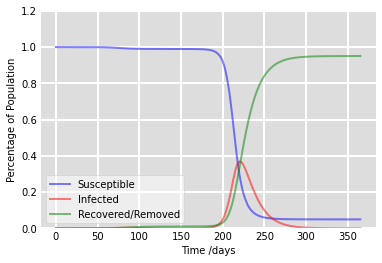

In [37]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from tqdm import tqdm

### ------------------- Parameters to Vary ------------------- ###

# lambda: number of people that a susceptible person interacts with per time step
# p: probability of getting infected if a susceptible person interacts with an infectious person
# gamma: recovery rate (recovery probability within one time step)
gamma = 1./14 # set lam = 2 vs 20, p = 0.3, gamma = 1/14

### ------------------- Fixed Parameters ------------------- ###

# Total population.
N = 300000000

# A grid of time points (in days) for the detecting period
t_set = np.linspace(0, 365, 366)

# Initial number of infected and immune individuals, I0 and R0.
I0, R0 = 10, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

# The SIR model differential equations.
def deriv_dynamic(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta(t) * S * I / N
    dIdt = beta(t) * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

x = np.linspace(0, 367, 368)

R_0_random = r0_true

def random_R_0(t):
    return R_0_random[int(t)]

def random_beta(t):
    return random_R_0(t) * gamma


### ----------------- Dynamic Parameters ----------------- ###

# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv_dynamic, y0, t_set, args=(N, random_beta, gamma))
S, I, R = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t_set, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t_set, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t_set, R/N, 'g', alpha=0.5, lw=2, label='Recovered/Removed')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percentage of Population')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [36]:
I_pred = I.copy()

In [38]:
I_true = I.copy()

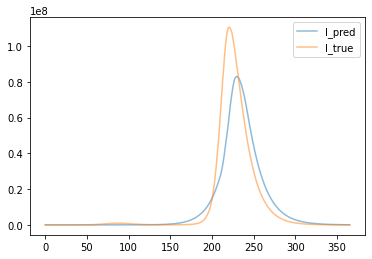

In [40]:
fig, ax = plt.subplots()

ax.plot(list(range(366)), I_pred, label="I_pred", alpha=0.5)
ax.plot(list(range(366)), I_true, label="I_true", alpha=0.5)
plt.legend()
plt.show()